# SpottedPy Tutorial


We will load anndata object in with multiple slides labelled in batch column. 
All signatures and cell types have been labelled in .obs column. 

In [ ]:
!pip install scanpy --upgrade
!pip install -U libpysal
!pip install esda

In [1]:
import scanpy as sc
import anndata as ad
import os
import numpy as np
import spottedpy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squidpy as sq
from tqdm import tqdm


Read in anndata and ensure columns we are interested in calculating hotspots from are labelled in .obs column and fill the columns without the labels with nan to ensure hotspot does not calculate them. Ensure batch is labelled as a string.

In [2]:
#read in anndata visium object
path="C:/Users/ellwi/Documents/projectR/cell2location_python_files/minor_cell_types_results_20000_epochs_worked/cell2location_map/slide_info_scores_package_anndata_0912.h5ad"
anndata_breast=sc.read_h5ad(path+"breast_anndata.h5ad")

# 1) Hotspot analysis

In [3]:
#.obs columns we are interested in calculating hotspots from
TME_labels=['hypoxia_hallmarks', 'angio_hallmarks', 'macrophage','nk_cells']
EMT_labels=['EMT_hallmarks']

Create hotspots for our EMT values and TME values. Hotspot and coldspots labels are found in .obs of anndata. 

In [4]:
for i in tqdm(TME_labels):
    anndata_breast=sp.create_hotspots(anndata_breast,column_name=i,neighbours_parameters=10)
#ensure we calculate hotspot from just tumour cells for emt_hallmarks
for i in tqdm(EMT_labels):
    anndata_breast=sp.create_hotspots(anndata_breast,filter_columns="tumour_cells",filter_value=1,column_name=i,neighbours_parameters=10)


100%|██████████| 1/1 [00:05<00:00,  5.42s/it]


In [5]:
#loop through TME_labels and add "_hot" to the end of each one so we calculate distances from them
TME_labels_hotspots=TME_labels.copy()
for i in range(0,len(TME_labels)):
    TME_labels_hotspots[i]=TME_labels[i]+'_hot'

In [21]:
#primary variables are the hotspots we calculate distances from
#comparison variables are the hotspots we calculate distances to
primary_variables_values=['EMT_hallmarks_hot', 'EMT_hallmarks_cold']
distances=sp.calculateDistances(anndata_breast,primary_variables=primary_variables_values,comparison_variables=TME_labels_hotspots)



Plot mean distances from primary variables to comparison variables

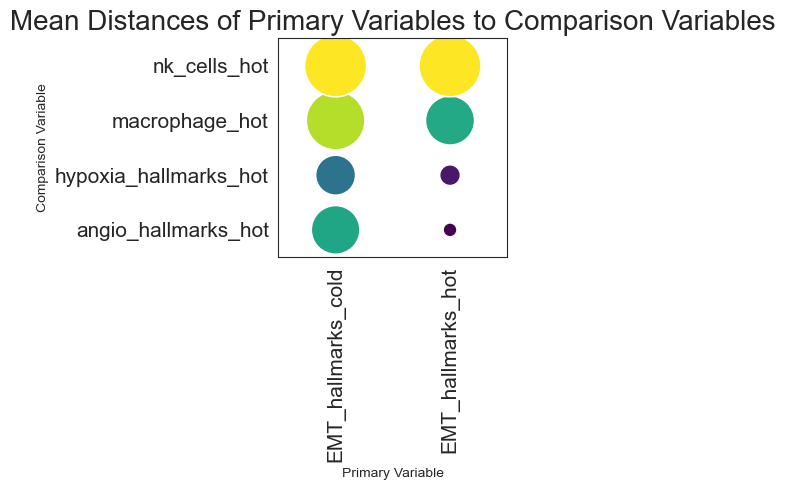

In [22]:
sp.plot_bubble_plot_mean_distances(distances,primary_vars=primary_variables_values,
                                        comparison_vars=TME_labels_hotspots,fig_size=(5,5))


Plot distribution of distances. Plots per comparison variable.

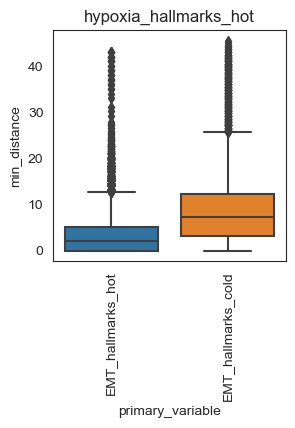

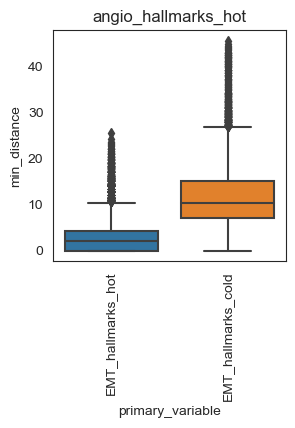

In [29]:
sp.plot_bar_plot_distance(distances,primary_variables=primary_variables_values,comparison_variables=['hypoxia_hallmarks_hot','angio_hallmarks_hot'],fig_size=(3,3))


Plot hotspots on each slide.

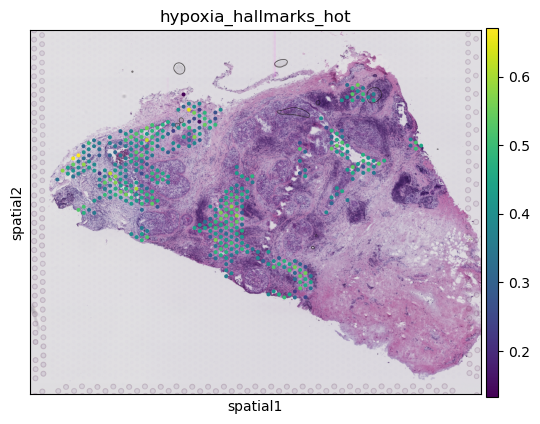

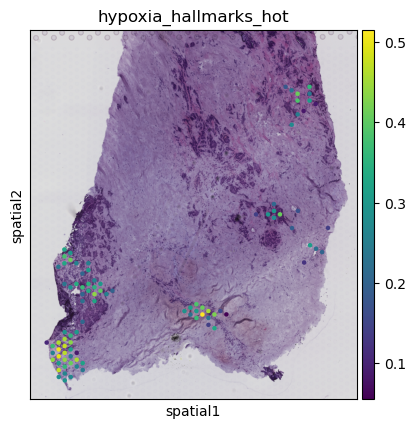

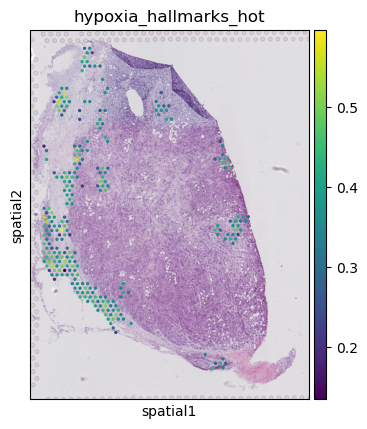

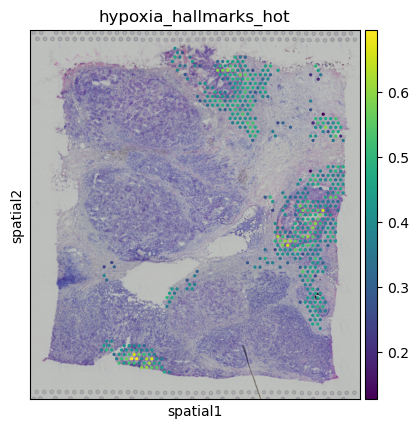

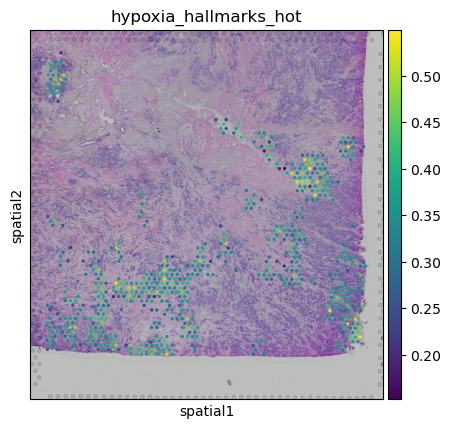

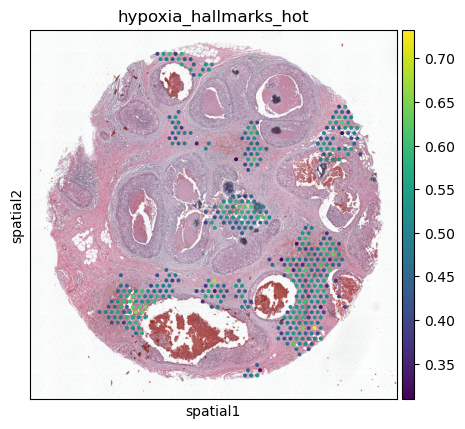

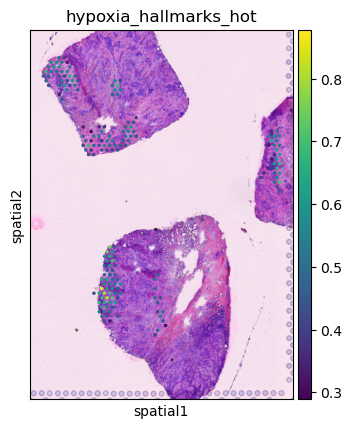

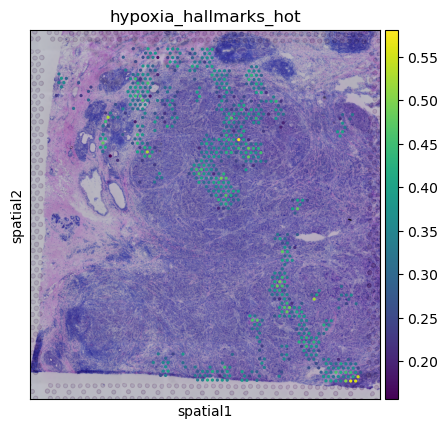

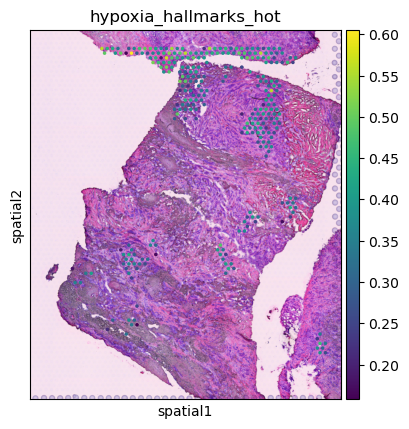

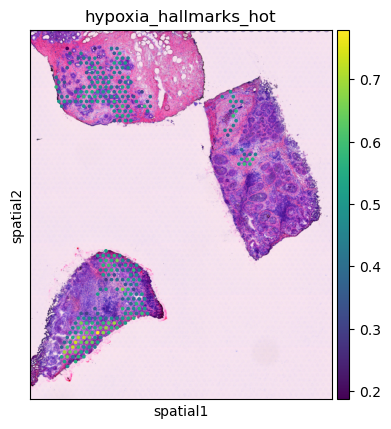

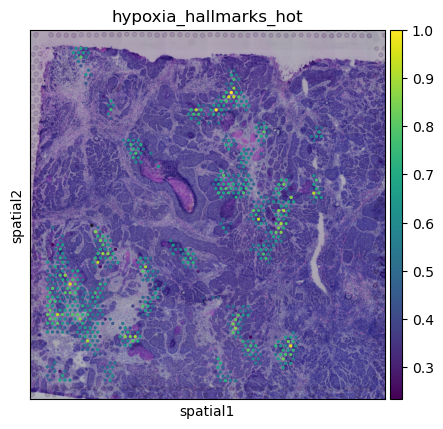

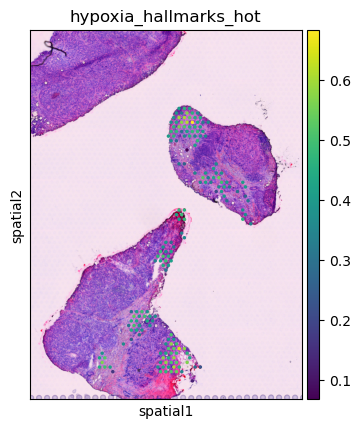

In [8]:
sp.plot_hotspots(anndata_breast,column_name="hypoxia_hallmarks_hot")

Choose two primary variables to compare in a comparison scatter plot. 

First value in primary_vars will be variable we subtract distances from for comparison. Therefore negative value means first primary variable is closer to comparison variable.

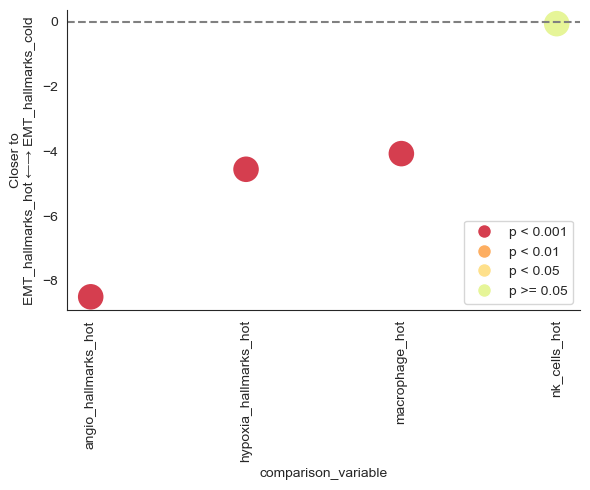

In [30]:

sp.plot_custom_scatter(data=distances, primary_vars=["EMT_hallmarks_hot","EMT_hallmarks_cold"], comparison_vars=["hypoxia_hallmarks_hot","EMT_hallmarks_cold","angio_hallmarks_hot",'macrophage_hot','nk_cells_hot'], bubble_size=(400,400),file_path_plots=None, fig_size=(6, 5))


Measuring gene signature scores in hotspots and compare scores within the hotspots. 

c:\Users\ellwi\anaconda3\lib\site-packages\scanpy\tools\_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
c:\Users\ellwi\anaconda3\lib\site-packages\scanpy\tools\_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
c:\Users\ellwi\anaconda3\lib\site-packages\scanpy\tools\_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
c:\Users\ellwi\anaconda3\lib\site-packages\scanpy\tools\_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
c:\Users\ellwi\anaconda3\lib\site-packages\scanpy\tools\_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` 

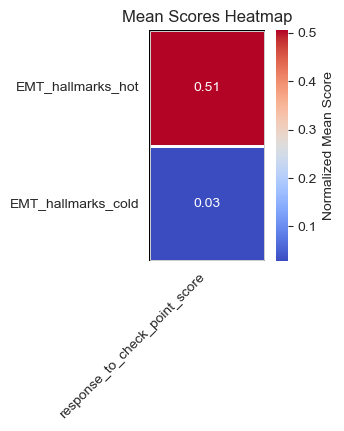

response_to_check_point_score
EMT_hallmarks_hot                        0.505332
EMT_hallmarks_cold                       0.027678

In [25]:
response_to_check_point=['STAT1','CCR5','CXCL9','CXCL10','CXCL11','PRF1','GZMA','HLA-DRA']
gene_lists = [response_to_check_point]  # List of genes for each signature
gene_list_names = ['response_to_check_point']  # Names for each gene list
states_to_loop_through = ['EMT_hallmarks_hot', 'EMT_hallmarks_cold']  # States to be analyzed
anndata_breast, signatures = sp.score_genes_by_batch(anndata_breast, gene_lists, gene_list_names)
#return data so we can perform further analysis
sp.plot_gene_heatmap(anndata_breast, signatures, states_to_loop_through, plot_score=True, normalize_values=False,fig_size=(3,3))


# Sensitivity Analysis


Lets increase hypoxiaa, angiogenesis and emt hotspot size and see how relationship changes

meta NOT subset; don't know how to subset; dropped


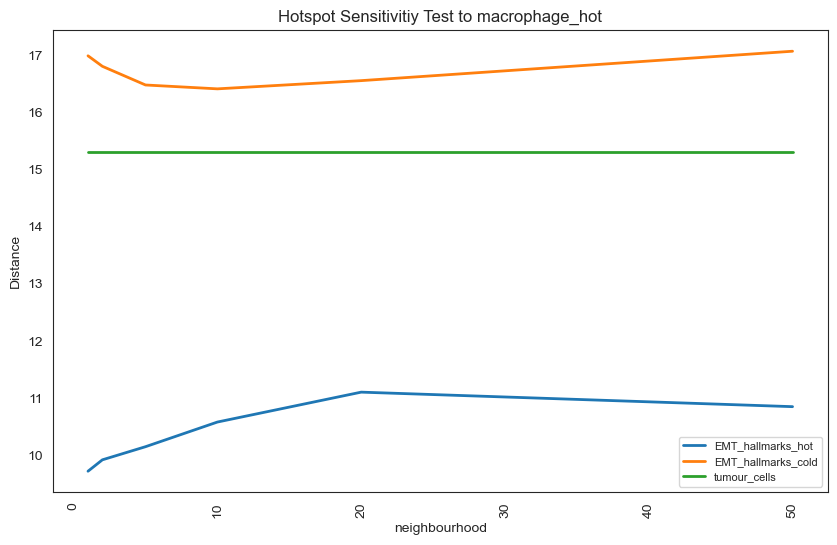

In [26]:
#Variable names (before _hot/_cold) need to be defined in .obs of anndata
#note: sensitivity_parameter is either pvalue or neighbourhood and defines whether we want to test effect of pvalue or neighbourhood on sensitivity. default then for both is either pvalue=0.05 or neighbourhood=10
#variable_one_two_is_tumour is true if both to be filtered in tumour defined cells. TODO: make this more flexible.  
"""
        params['variable_comparison'] is the variable that is being compared to the other variables
        - params (dict): A dictionary with the following keys:
        * 'variable_comparison' (str): Name of the variable used for comparison.
        * 'variable_comparison_tumour' (bool): Indicates if data should be filtered for tumor cells for 'variable_comparison'.
        * 'sensitivity_parameter' (str): Specifies the sensitivity analysis parameter type ('pvalue' or 'neighbourhood').
        * 'variable_one' (str), 'variable_two' (str): Names of primary variables for distance calculation.
        * 'variable_one_two_is_tumour' (bool): Indicates if data should be filtered for tumor cells for 'variable_one' and 'variable_two'.
        * 'variable_three' (str): Reference variable for distance calculation. E.g .obs['tumour_cells']. Do not calculate hotspot for this. Remember: values in .obs in column without reference value should be nan.
        * 'values_to_test' (list): List of values to test for the sensitivity analysis.
        * 'file_name' (str): Name of the file to save the plot.
"""
"""
#e.g. testing pvalue
params = {
    'variable_comparison': "macrophage_hot",
    'variable_one': "EMT_hallmarks_hot",
    'variable_two': "EMT_hallmarks_cold",
    #reference value, i.e. no hotspots calculated from it
    'variable_three': "tumour_cells",
    'values_to_test': [0.001,0.005,0.01,0.05,0.1,0.2],
    'variable_comparison_constant': True,
    'variable_comparison_tumour': False,
    'variable_one_two_is_tumour': True,
    'file_name': "sensitivity_plot_macrophage",
    'sensitivity_parameter': "pvalue"
}
"""

#testing neighbourhood
params = {
    'variable_comparison': "macrophage_hot",
    'variable_one': "EMT_hallmarks_hot",
    'variable_two': "EMT_hallmarks_cold",
    #reference value, i.e. no hotspots calculated from it
    'variable_three': "tumour_cells",
    'values_to_test': [1,2,5,10,20,50],
    'variable_comparison_constant': True,
    'variable_comparison_tumour': False,
    'variable_one_two_is_tumour': True,
    'file_name': "sensitivity_plot_macrophage",
    'sensitivity_parameter': "neighbourhood"
}
results = sp.sensitivity_calcs(anndata_breast, params)


12


c:\Users\ellwi\Documents\GitHub\spottedPy\spottedpy.py:702: UserWarning: FixedFormatter should only be used together with FixedLocator
  labels=grouped_data['comparison_variable'].unique()
meta NOT subset; don't know how to subset; dropped


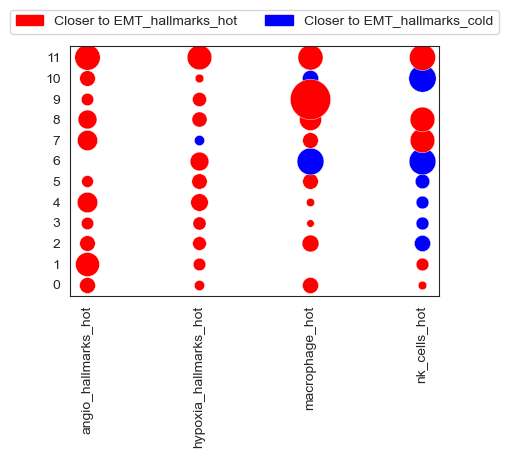

In [27]:
#differences per batch (i.e. slide)
#returns distances for further analysis if needed
data=sp.plot_bubble_chart_by_batch(distances, primary_variable_value='EMT_hallmarks_hot',
                               comparison_variable_values=['hypoxia_hallmarks_hot', 'angio_hallmarks_hot','EMT_hallmarks_cold','macrophage_hot','nk_cells_hot'],
                               reference_variable="EMT_hallmarks_cold",
                               save_path="bubble_chart_by_batch.pdf",
                               pval_cutoff=0.05,
                               fig_size=(5,5))


# 2) Neighbourhood correlation (correlate signatures within different neighbourhood settings)

Given the source_nodes (here filtered for tumour spots), we can calculate the correlation between signatures in the neighbourhood of each source node. Rings range specifies spatial unit. 

In [ ]:
#results (dict): A dictionary where each key is the number of rings used for neighbor calculation, and each  value is a tuple containing the correlation matrix and the corresponding p-values matrix for those rings.
results = sp.calculate_neighbourhood_correlation(rings_range=[1,2,3], 
                                                           adata_vis=anndata_breast,
                                                           neighbour_variables=anndata_breast.obs[['EMT_hallmarks', 'hypoxia_hallmarks', 'angio_hallmarks', 'macrophage', 'nk_cells']],
                                                           source_nodes=anndata_breast[anndata_breast.obs['tumour_cells']==1].obs.index)


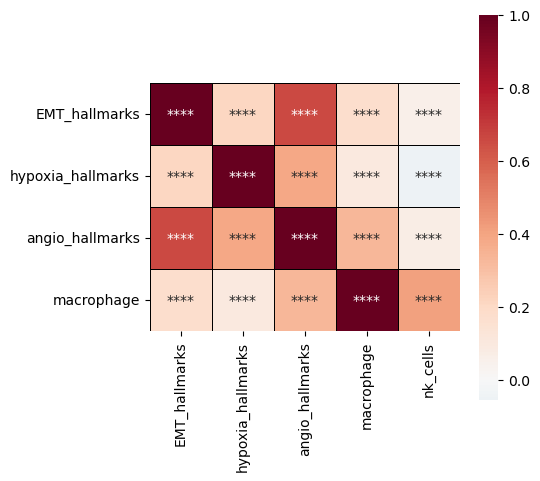

In [4]:
#select ring number to plot as a heatmap
sp.correlation_heatmap_neighbourhood(results[1], 'EMT_hallmarks', 'hypoxia_hallmarks', 'angio_hallmarks', 'macrophage',path_to_save="test.pdf",fig_size=(5,5))


meta NOT subset; don't know how to subset; dropped


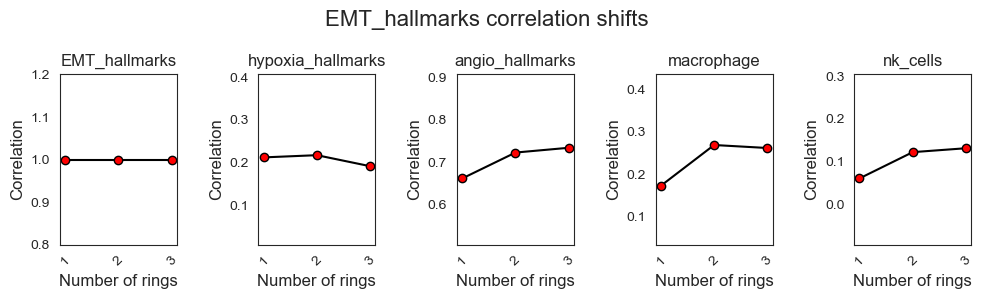

In [5]:
sp.plot_correlation_shifts(results,correlation_primary_variable='EMT_hallmarks',file_path="correlation_shifts.pdf")

meta NOT subset; don't know how to subset; dropped


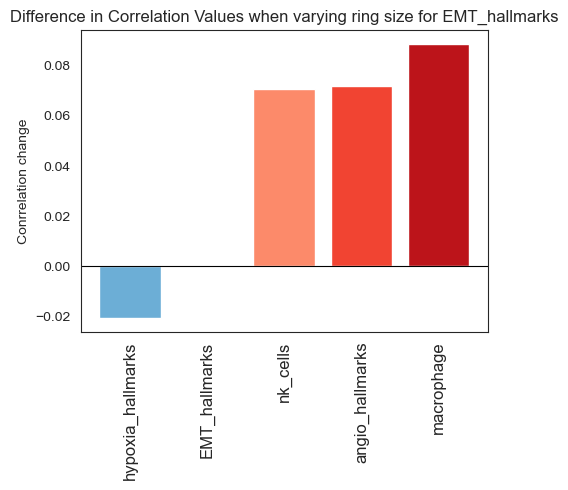

In [6]:
sp.plot_overall_change(results,correlation_primary_variable='EMT_hallmarks',file_path="overall_change.pdf",fig_size=(5,5))

# Correlate inner ring with outer ring (neighbourhood enrichment)

Takes longer than above. A different spatial unit approach, correlate inner ring with outer ring. Specify inner nodes for correlation e.g. tumour cells

In [ ]:
results_inner_outer=sp.calculate_inner_outer_neighbourhood_enrichment(rings_range=[1,2,3,5,10],adata_vis=anndata_breast,
                                                                           neighbour_variables=anndata_breast.obs[['EMT_hallmarks', 'hypoxia_hallmarks', 'angio_hallmarks', 'macrophage', 'nk_cells']],
                                                                           source_nodes=anndata_breast[anndata_breast.obs['tumour_cells']==1].obs.index)

In [ ]:
#using cell abundance from calculate_inner_outer_neighbourhood_enrichment, we calculate corr_df and pval that we can use to plot using functions previoulsy defined
#correlation_key_variable is the inner ring variable we want to correlate with the other variables in the outer rings
results_corr=sp.calculate_corr_pvalue_for_inner_outer_neighbourhood_enrichment(results_inner_outer,
                                                                               correlation_key_variable=['EMT_hallmarks'],
                                                                               rings_range=[1,2,3,5,10])


In [ ]:
sp.plot_correlation_shifts(results,correlation_primary_variable='EMT_hallmarks',file_path="correlation_shifts_inner_outer.pdf")